# Read in Data, change csv for different property

In [103]:
import pandas as pd
property_name = '1Eleven'
file_path = "1Eleven_filtered_output.csv"
oneElevenDf = pd.read_csv(file_path)
oneElevenDf['Event Date'] = pd.to_datetime(oneElevenDf['Event Date'], errors='coerce')
oneElevenDf = oneElevenDf[oneElevenDf['Event Date'] >= pd.Timestamp('2023-08-01')]
oneElevenDf

C:\Users\JackE\AppData\Local\Temp\ipykernel_14760\1698660548.py:4: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  oneElevenDf = pd.read_csv(file_path)


,Event Date,Property Name,Property Year Built,Unit Space ID,Unit Type,Unit Status,Bathroom Count,Bedroom Count,Square Feet,Available On,Budgeted Rent,Lease Start Date,Lease End Date,Scheduled Rent,Scheduled Charges,Market Rent
146339,2023-08-01,1Eleven,2015,5333160,DBLPLAT,Notice Rented,1,2,0,9/3/2023,1150,9/3/2022,8/31/2025,1300.00,1350.00,1150
146340,2023-08-01,1Eleven,2015,5333381,DBLPLAT,Notice Rented,1,2,0,9/3/2023,1150,9/3/2021,8/31/2024,1050.00,1100.00,1150
146341,2023-08-01,1Eleven,2015,5333162,SINGLE,Occupied No Notice,1,1,0,9/6/2022,1515,9/3/2022,8/31/2024,1400.00,1475.00,1515
146342,2023-08-01,1Eleven,2015,5333385,QUAD,Notice Rented,2,4,0,9/3/2023,795,9/3/2022,8/31/2025,785.00,835.00,795
146343,2023-08-01,1Eleven,2015,5333387,QUAD,Notice Rented,2,4,0,9/3/2023,795,1/5/2022,12/31/2024,735.00,785.00,795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410255,2025-08-06,1Eleven,2015,5333869,SINGDLX,Occupied No Notice,1,1,0,8/27/2023,2217,9/3/2023,8/31/2026,1716.88,1819.38,1675
410256,2025-08-06,1Eleven,2015,5333649,SINGDLX,Occupied No Notice,1,1,0,8/27/2024,2217,9/3/2024,8/27/2027,1700.00,1800.00,1800
410257,2025-08-06,1Eleven,2015,5333650,SINGDLX,Occupied No Notice,1,1,0,9/3/2021,2217,9/1/2024,NaN,1563.13,1691.26,1675
410258,2025-08-06,1Eleven,2015,5333652,SINGDLX,Occupied No Notice,1,1,0,8/27/2023,2217,9/3/2023,8/26/2026,1716.88,1819.38,1775


### We define the Revenue Per Available Room (by Day) as Average Revenue x Current Occupation where:
Average Revenue = Sum of Scheduled Rent divided by Count of Occupied Rooms \
Current Occupation = Count of Occupied Rooms divided by Count of Rooms. \
This then simplifies to Revenue Per Available Room is equal to sum of scheduled rent divided by Count of rooms 

In [104]:
# Group by date
daily_summary = oneElevenDf.groupby('Event Date').agg(
    total_revenue=('Scheduled Rent', 'sum'),
    all_units=('Unit Status', 'count')  # count of rows/units per day
)

# Compute RevPAR
daily_summary['AverageRevenue'] = daily_summary['total_revenue'] / daily_summary['all_units']
daily_summary

,total_revenue,all_units,AverageRevenue
Event Date,,,
2023-08-01,385168.56,361,1066.94892
2023-08-02,385168.56,361,1066.94892
2023-08-03,385168.56,361,1066.94892
2023-08-04,385168.56,361,1066.94892
2023-08-05,385168.56,361,1066.94892
...,...,...,...
2025-08-02,377138.52,357,1056.41042
2025-08-03,377138.52,357,1056.41042
2025-08-04,377138.52,357,1056.41042


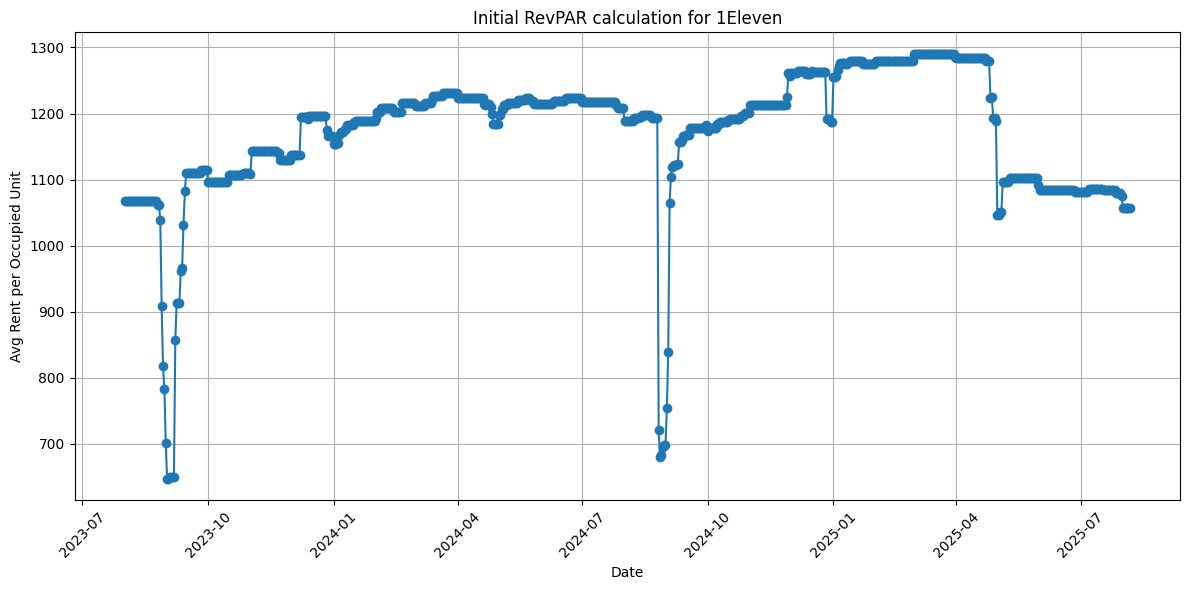

In [105]:
import matplotlib.pyplot as plt

# Clean up Event Date to remove the timestamp
daily_summary.index = daily_summary.index.date

# Plot RevPAR over time
plt.figure(figsize=(12, 6))
plt.plot(daily_summary.index, daily_summary['AverageRevenue'], marker='o', linewidth=1.5)
plt.title(f'Initial RevPAR calculation for {property_name}')
plt.xlabel('Date')
plt.ylabel('Avg Rent per Occupied Unit')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Cleaned Up RevPAR plot

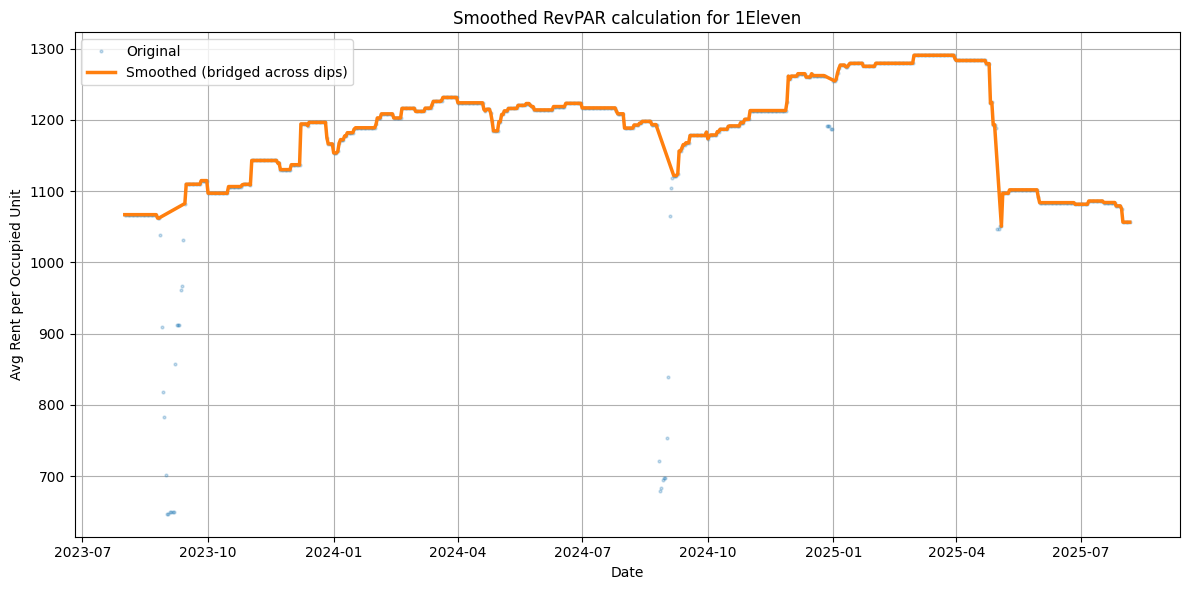

In [106]:
daily_summary = daily_summary.sort_index().copy()
daily_summary.index = pd.to_datetime(daily_summary.index)

s = daily_summary['AverageRevenue']

win = 45                
pct_thresh = 0.95        
max_run_days = 30        

med = s.rolling(win, center=True, min_periods=1).median()
bad = s < pct_thresh * med

bad = bad.rolling(3, center=True, min_periods=1).max().astype(bool)

grp = (bad != bad.shift(fill_value=False)).cumsum()
run_len = bad.groupby(grp).transform('size')
bridge_mask = bad & (run_len <= max_run_days)

s_bridged = s.mask(bridge_mask).interpolate(method='time', limit_direction='both')
daily_summary['AverageRevenue_bridged'] = s_bridged

plt.figure(figsize=(12,6))
plt.plot(s.index, s, 'o', ms=2, alpha=0.25, label='Original')
plt.plot(s_bridged.index, s_bridged, linewidth=2.5, label='Smoothed (bridged across dips)')
plt.title(f"Smoothed RevPAR calculation for {property_name}")
plt.xlabel('Date')
plt.ylabel('Avg Rent per Occupied Unit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Sanity Check Lease Start Dates
##### Doing this because I want to confirm if the drops are just the weird period where a room is being cleaned for the next renter

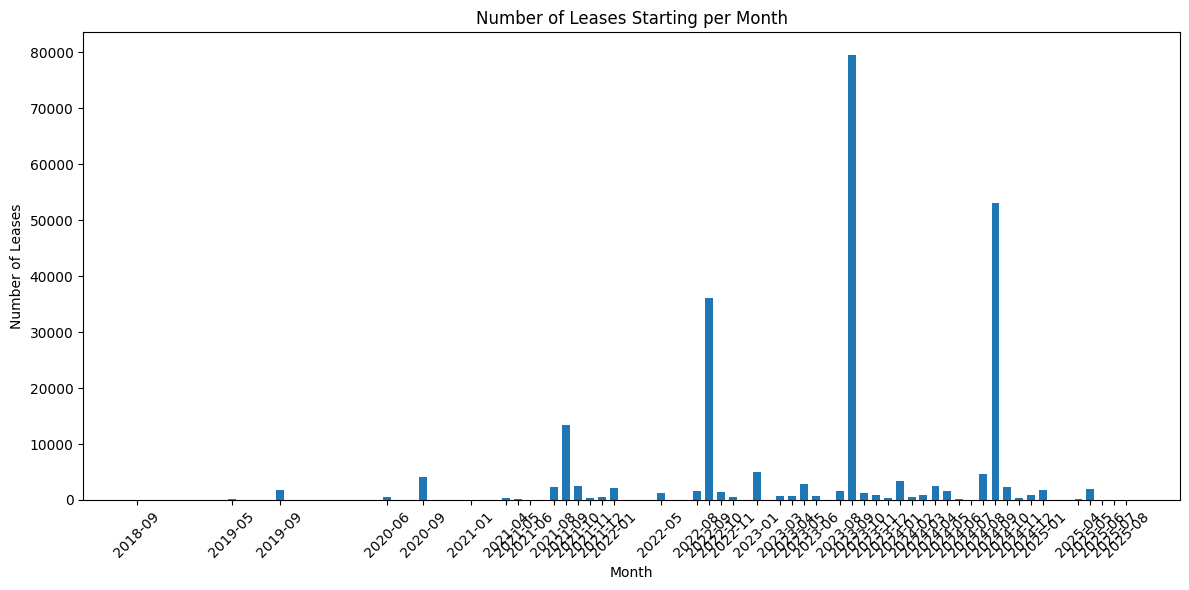

In [107]:
# Ensure Lease Start Date is datetime
oneElevenDf['Lease Start Date'] = pd.to_datetime(oneElevenDf['Lease Start Date'])

# Group by month and count leases
lease_starts_monthly = (
    oneElevenDf
    .groupby(oneElevenDf['Lease Start Date'].dt.to_period('M'))
    .size()
    .reset_index(name='leases_started')
)

# Convert Period to timestamp for plotting
lease_starts_monthly['Lease Start Date'] = lease_starts_monthly['Lease Start Date'].dt.to_timestamp()

# Plot histogram-style bar chart with month labels
plt.figure(figsize=(12,6))
plt.bar(lease_starts_monthly['Lease Start Date'], lease_starts_monthly['leases_started'], width=20)
plt.title('Number of Leases Starting per Month')
plt.ylabel('Number of Leases')
plt.xlabel('Month')

# Format x-axis to show month-year
plt.xticks(
    lease_starts_monthly['Lease Start Date'],
    lease_starts_monthly['Lease Start Date'].dt.strftime('%Y-%m'),
    rotation=45
)

plt.tight_layout()
plt.show()

### Initial Vacancy Plot and Correlation between Occupied -> Vacant transition

C:\Users\JackE\AppData\Local\Temp\ipykernel_14760\4033023317.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  oneElevenDf['Event Date'] = pd.to_datetime(oneElevenDf['Event Date'], errors='coerce', infer_datetime_format=True)


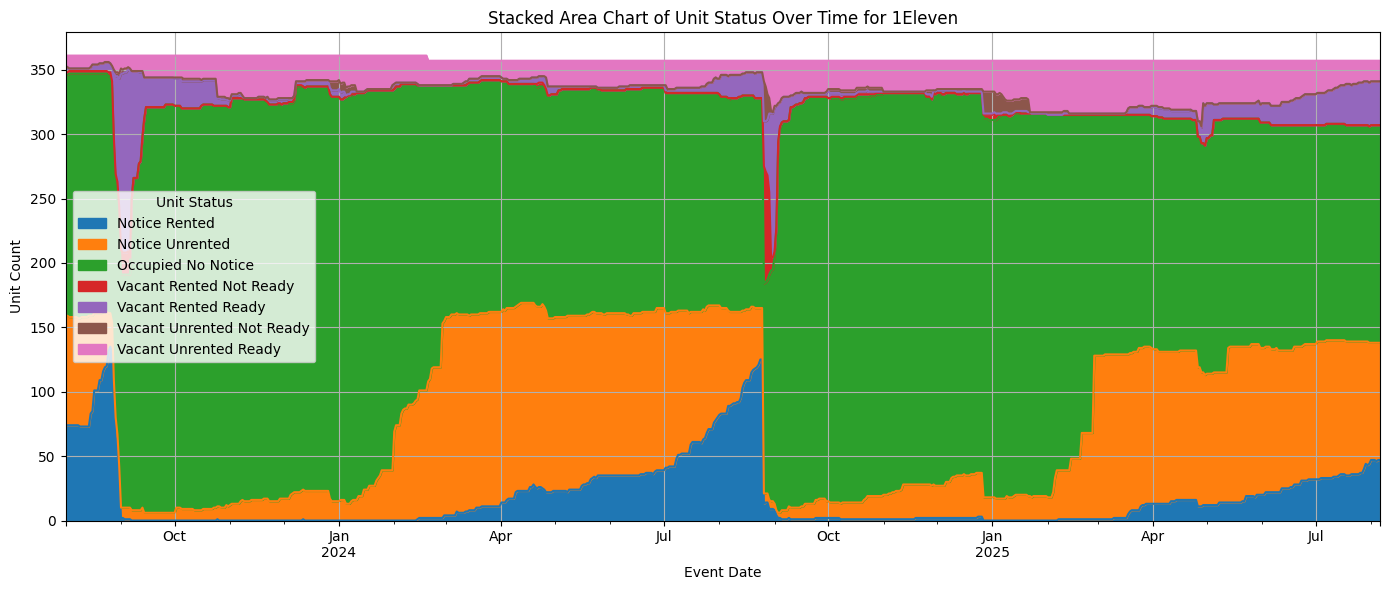

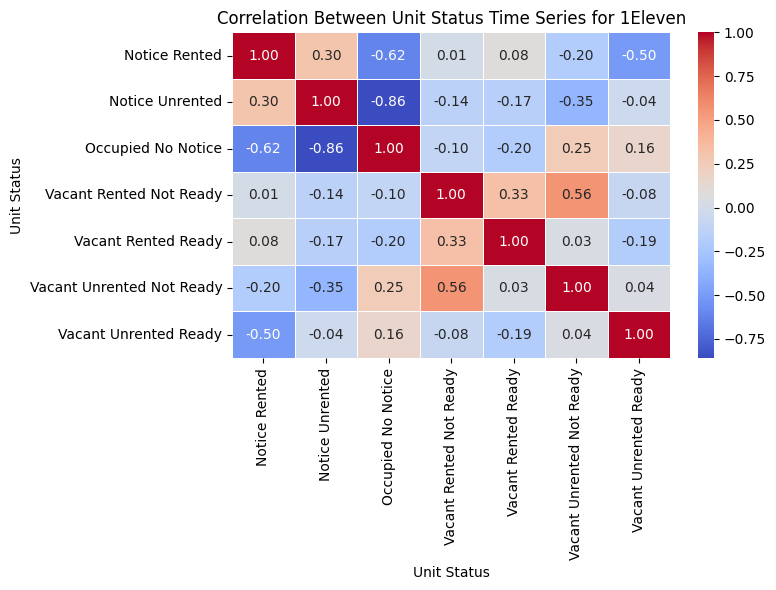

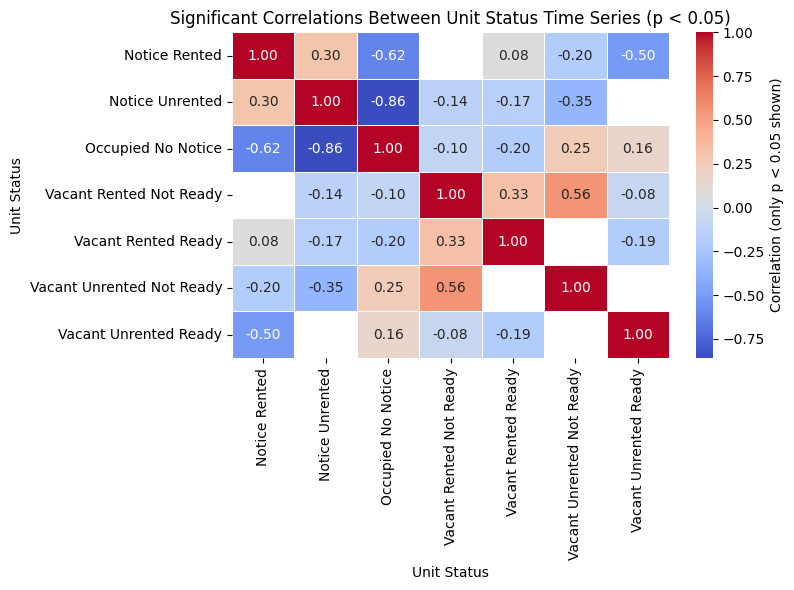

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Parse Event Date as datetime (mixed formats just in case)
oneElevenDf['Event Date'] = pd.to_datetime(oneElevenDf['Event Date'], errors='coerce', infer_datetime_format=True)

# Group by date and unit status, count unique Unit Space IDs
summary = (
    oneElevenDf.groupby(['Event Date', 'Unit Status'])['Unit Space ID']
      .nunique()
      .reset_index(name='Unit Count')
    .sort_values('Event Date')
)

# Pivot so we get one column per Unit Status, rows by date
pivoted = summary.pivot(index='Event Date', columns='Unit Status', values='Unit Count')

# Line Plot
# ax = pivoted.plot(
#     marker='o',
#     figsize=(14,6),
#     title=f"Count of Unit Status Over Time for 1Eleven"
# )
# plt.ylabel("Unit Count")
# plt.xlabel("Event Date")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Bar Plot
pivoted.plot(
    kind='area',
    stacked=True,
    figsize=(14, 6),
    title="Stacked Area Chart of Unit Status Over Time for 1Eleven"
)
plt.ylabel("Unit Count")
plt.xlabel("Event Date")
plt.grid(True)
plt.tight_layout()
plt.show()

# get correlation Matrix
pivoted_clean = pivoted.fillna(0).asfreq('D', fill_value=0)
correlation_matrix = pivoted_clean.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Unit Status Time Series for 1Eleven")
plt.tight_layout()
plt.show()

# Create a significance matrix
pvals = pd.DataFrame(index=pivoted_clean.columns, columns=pivoted_clean.columns)

for col1 in pivoted_clean.columns:
    for col2 in pivoted_clean.columns:
        corr, pval = pearsonr(pivoted_clean[col1], pivoted_clean[col2])
        pvals.loc[col1, col2] = pval

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            mask=pvals.astype(float) > 0.05,  # mask non-significant
            cbar_kws={'label': 'Correlation (only p < 0.05 shown)'})
plt.title("Significant Correlations Between Unit Status Time Series (p < 0.05)")
plt.tight_layout()
plt.show()

### Autocorrelation of Vacancy Status

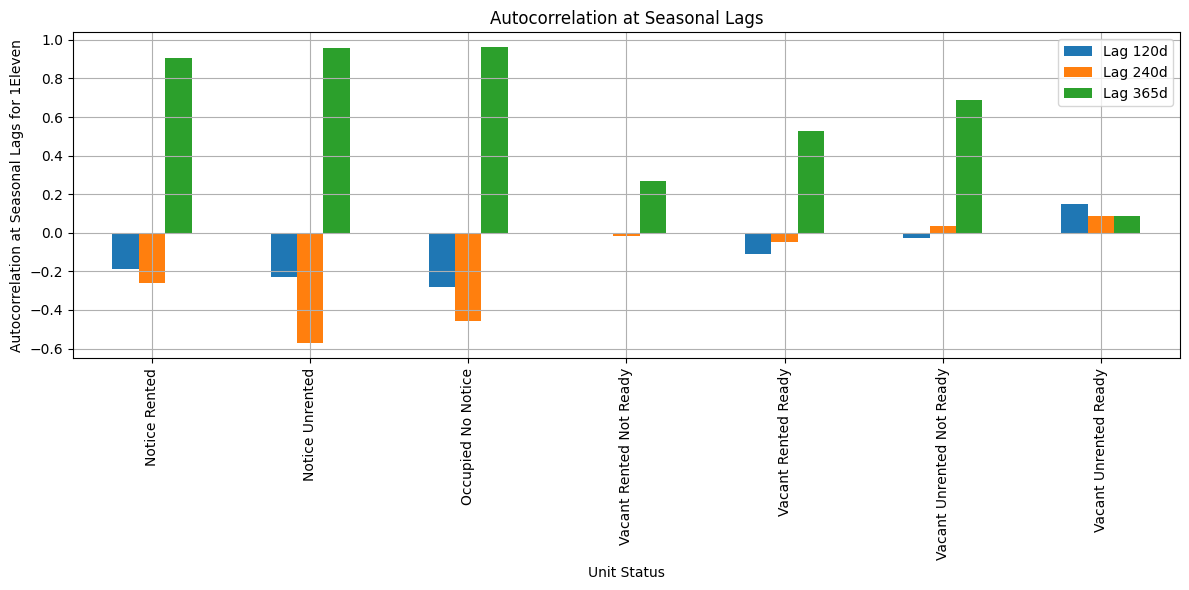

In [109]:
# Clean up time series by replacing na's with 0's
# Can also drop points but might get weird when it comes to correlations because everything has to be the same length? 
pivoted_clean = pivoted.fillna(0).asfreq('D', fill_value=0)

# Define lags in days -> We don't have enough data for longer lags I think
lags = [120, 240, 365]
autocorr_results = {}

# Calculate autocorrelations
for status in pivoted_clean.columns:
    autocorrs = {f"Lag {lag}d": pivoted_clean[status].autocorr(lag=lag) for lag in lags}
    autocorr_results[status] = autocorrs

# Convert to DataFrame
autocorr_df = pd.DataFrame(autocorr_results).T
autocorr_df.index.name = "Unit Status"
autocorr_df.plot(kind='bar', figsize=(12, 6), title='Autocorrelation at Seasonal Lags')
plt.ylabel("Autocorrelation at Seasonal Lags for 1Eleven")
plt.grid(True)
plt.tight_layout()
plt.show()


### Variance Checking

In [110]:
from scipy.stats import zscore

# Clean and prepare data for correlation
pivoted_clean = pivoted.fillna(0).asfreq('D', fill_value=0)

variances = pivoted_clean.var()
print("Variance of Unit Status Time Series:")
print(variances.sort_values(ascending=False))

# Standardize using z-score
pivoted_zscore = pivoted_clean.apply(zscore, nan_policy='omit')

# Correlation matrix on standardized data
correlation_matrix = pivoted_zscore.corr()

variances = pivoted_zscore.var()
print("Variance of Unit Status Time Series:")
print(variances.sort_values(ascending=False))

Variance of Unit Status Time Series:
Unit Status
Occupied No Notice           4028.190951
Notice Unrented              2597.933175
Notice Rented                 743.087580
Vacant Rented Ready           347.655275
Vacant Unrented Ready          79.456116
Vacant Rented Not Ready        38.821644
Vacant Unrented Not Ready       9.512897
dtype: float64
Variance of Unit Status Time Series:
Unit Status
Vacant Rented Not Ready      1.001359
Vacant Unrented Ready        1.001359
Vacant Rented Ready          1.001359
Vacant Unrented Not Ready    1.001359
Notice Rented                1.001359
Notice Unrented              1.001359
Occupied No Notice           1.001359
dtype: float64


### Unit Status Actual Changes

In [111]:
df = oneElevenDf
df = df.sort_values(['Unit Space ID', 'Event Date'])

# Create a group that identifies consecutive same-status runs
df['Prev Status'] = df.groupby('Unit Space ID')['Unit Status'].shift()
df['New Phase'] = df['Unit Status'] != df['Prev Status']

# Cumulative sum to assign a unique phase ID
df['Phase ID'] = df.groupby('Unit Space ID')['New Phase'].cumsum()

# Now summarize each phase
phase_lengths = (
    df.groupby(['Unit Space ID', 'Phase ID', 'Unit Status'])
      .agg(
          Phase_Start=('Event Date', 'min'),
          Phase_End=('Event Date', 'max'),
          Days_In_Phase=('Event Date', 'count')  # <- true number of days in that phase
      )
      .reset_index()
)

print(phase_lengths)

      Unit Space ID  Phase ID            Unit Status Phase_Start  Phase_End  \
0           5333160         1          Notice Rented  2023-08-01 2023-08-26   
1           5333160         2    Vacant Rented Ready  2023-08-27 2023-09-06   
2           5333160         3     Occupied No Notice  2023-09-07 2025-08-06   
3           5333162         1     Occupied No Notice  2023-08-01 2024-05-26   
4           5333162         2        Notice Unrented  2024-05-27 2024-08-25   
...             ...       ...                    ...         ...        ...   
2393        5352454         5    Vacant Rented Ready  2025-04-29 2025-08-06   
2394        5352455         1  Vacant Unrented Ready  2023-08-01 2024-08-21   
2395        5352455         2    Vacant Rented Ready  2024-08-22 2024-09-02   
2396        5352455         3     Occupied No Notice  2024-09-03 2025-02-04   
2397        5352455         4        Notice Unrented  2025-02-05 2025-08-06   

      Days_In_Phase  
0                26  
1      

In [112]:
# Sort by unit and phase start
phase_lengths = phase_lengths.sort_values(['Unit Space ID', 'Phase_Start'])

# Shift to get previous phase info
phase_lengths['Prev Status'] = phase_lengths.groupby('Unit Space ID')['Unit Status'].shift()
phase_lengths['Prev Phase End'] = phase_lengths.groupby('Unit Space ID')['Phase_End'].shift()
phase_lengths['Gap'] = (phase_lengths['Phase_Start'] - phase_lengths['Prev Phase End']).dt.days


In [113]:
from collections import defaultdict

# Create a dictionary to hold list of durations for each transition
transition_durations = defaultdict(list)

# Iterate through rows where both current and previous status exist
for _, row in phase_lengths.dropna(subset=['Prev Status']).iterrows():
    transition = (row['Prev Status'], row['Unit Status'])
    duration = row['Days_In_Phase']  # Or use 'Gap' if you want time *between* phases
    transition_durations[transition].append(duration)


In [114]:
# Build final summary of averages
summary = []

for transition, durations in transition_durations.items():
    from_status, to_status = transition
    avg_duration = sum(durations) / len(durations)
    summary.append({
        'From': from_status,
        'To': to_status,
        'Count': len(durations),
        'Average Duration': round(avg_duration, 2)
    })

transition_summary_df = pd.DataFrame(summary).sort_values('Average Duration', ascending=False)
print(transition_summary_df)


                         From                         To  Count  \
1         Vacant Rented Ready         Occupied No Notice    338   
13    Vacant Rented Not Ready         Occupied No Notice     20   
14      Vacant Unrented Ready         Occupied No Notice     47   
10            Notice Unrented         Occupied No Notice     18   
20              Notice Rented         Occupied No Notice      9   
25  Vacant Unrented Not Ready         Occupied No Notice     11   
17         Occupied No Notice      Vacant Unrented Ready     10   
2          Occupied No Notice            Notice Unrented    424   
28        Vacant Rented Ready              Notice Rented      2   
30        Vacant Rented Ready            Notice Unrented      3   
32    Vacant Rented Not Ready              Notice Rented      1   
4   Vacant Unrented Not Ready      Vacant Unrented Ready     71   
19              Notice Rented      Vacant Unrented Ready      4   
9         Vacant Rented Ready      Vacant Unrented Ready     4

### Second Pass
#### Read in data, categorize unit status and type cast columns

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_path = "1Eleven_filtered_output.csv"

df = pd.read_csv(csv_path, low_memory=False)
df["Event Date"] = pd.to_datetime(df["Event Date"], errors="coerce")
df = df[df["Event Date"].notna()]

df = df[df["Event Date"] >= pd.Timestamp("2023-08-01")]
df["Scheduled Rent"] = pd.to_numeric(df["Scheduled Rent"], errors="coerce").fillna(0.0)

def status_cat(s):
    if s in ["Occupied No Notice", "Notice Unrented", "Notice Rented"]:
        return "occupied"        # physically occupied today
    elif s in ["Vacant Rented Ready", "Vacant Rented Not Ready"]:
        return "preleased"       # leased but not physically occupied
    elif s in ["Vacant Unrented Ready", "Vacant Unrented Not Ready"]:
        return "vacant"          # available but not leased
    else:
        return "other"
    

df["status_cat"] = df["Unit Status"].map(status_cat)

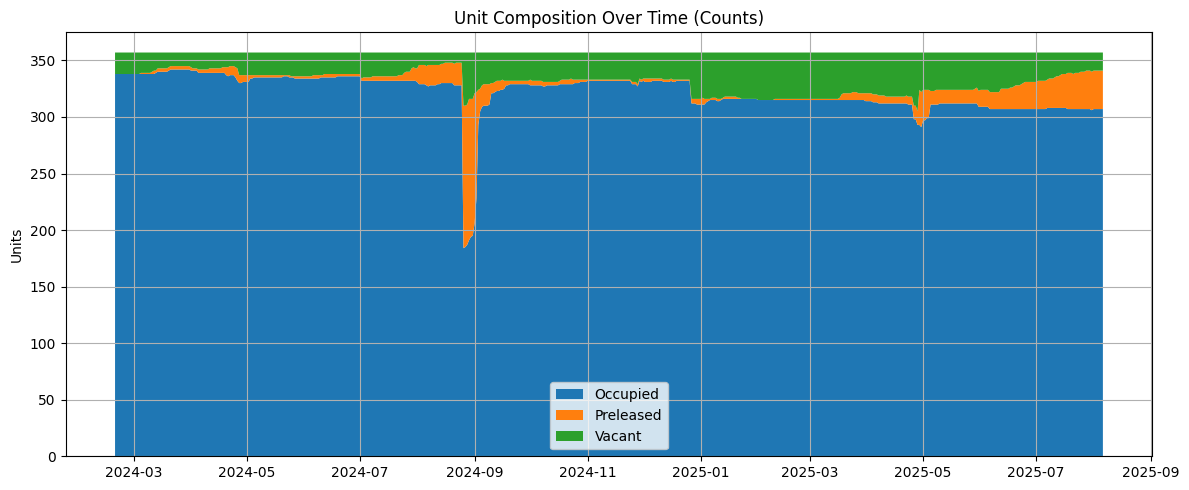

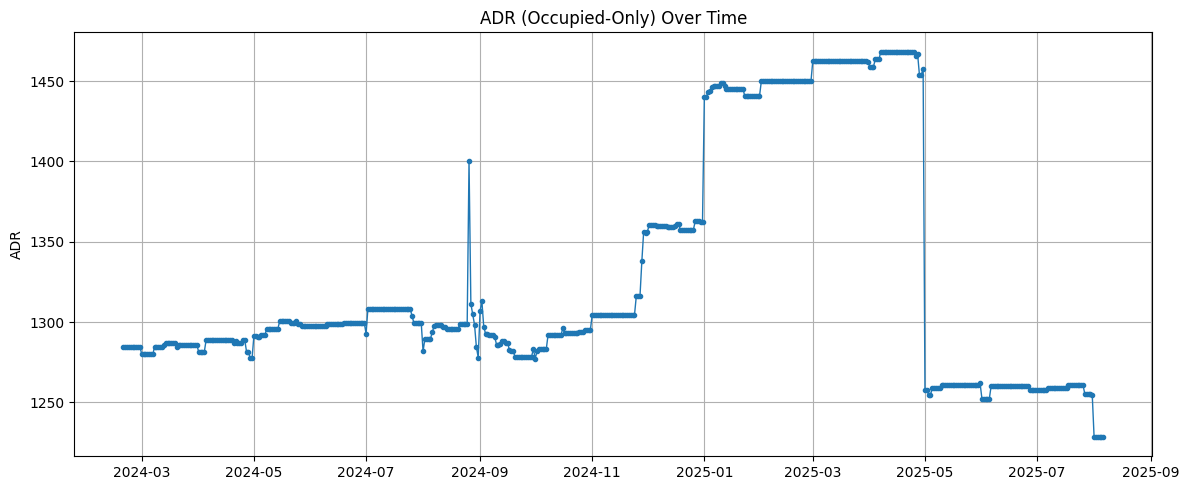

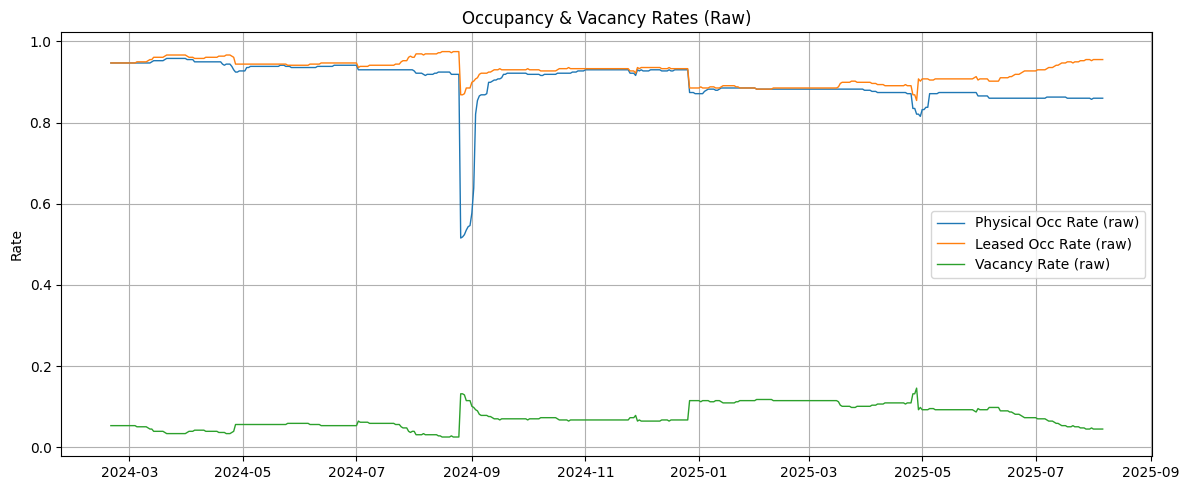

In [ ]:
# daily counts by category (unique units)
counts = (
    df.groupby(["Event Date","status_cat"])["Unit Space ID"]
      .nunique()
      .unstack(fill_value=0)
      .sort_index()
)

for c in ["occupied","vacant","preleased"]:
    if c not in counts.columns: counts[c] = 0

counts["total_units"] = counts[["occupied","vacant","preleased"]].sum(axis=1)

# Optional: stable-inventory filter (within +/-2 of modal daily unit count)
mode_units = counts["total_units"].mode().iloc[0]
stable = counts[(counts["total_units"] >= mode_units-2) & (counts["total_units"] <= mode_units+2)].copy()

# ADR from physically occupied rows only
occ = (
    df[df["status_cat"]=="occupied"]
    .groupby("Event Date")
    .agg(occ_units=("Unit Space ID","nunique"),
         total_occ_rent=("Scheduled Rent","sum"))
    .sort_index()
)
occ["ADR_occ"] = occ["total_occ_rent"] / occ["occ_units"]

# join metrics
daily = stable.join(occ, how="left")

# rates (raw)
daily["physical_occ_rate"] = daily["occupied"] / daily["total_units"]
daily["leased_occ_rate"]   = (daily["occupied"] + daily["preleased"]) / daily["total_units"]
daily["vacancy_rate"]      = daily["vacant"] / daily["total_units"]

# initial RevPAR (raw)
daily["RevPAR_raw"] = daily["ADR_occ"] * daily["physical_occ_rate"]
daily = daily.sort_index()

# Unit composition over time (stacked area of counts)
plt.figure(figsize=(12,5))
plt.stackplot(daily.index, daily["occupied"], daily["preleased"], daily["vacant"], labels=["Occupied","Preleased","Vacant"])
plt.title("Unit Composition Over Time (Counts)")
plt.ylabel("Units")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ADR (occupied-only) over time
plt.figure(figsize=(12,5))
plt.plot(daily.index, daily["ADR_occ"], marker=".", linewidth=1)
plt.title("ADR (Occupied-Only) Over Time")
plt.ylabel("ADR")
plt.grid(True)
plt.tight_layout()
plt.show()

# Physical occupancy, leased occupancy, and vacancy (raw)
plt.figure(figsize=(12,5))
plt.plot(daily.index, daily["physical_occ_rate"], linewidth=1, label="Physical Occ Rate (raw)")
plt.plot(daily.index, daily["leased_occ_rate"],   linewidth=1, label="Leased Occ Rate (raw)")
plt.plot(daily.index, daily["vacancy_rate"],      linewidth=1, label="Vacancy Rate (raw)")
plt.title("Occupancy & Vacancy Rates (Raw)")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

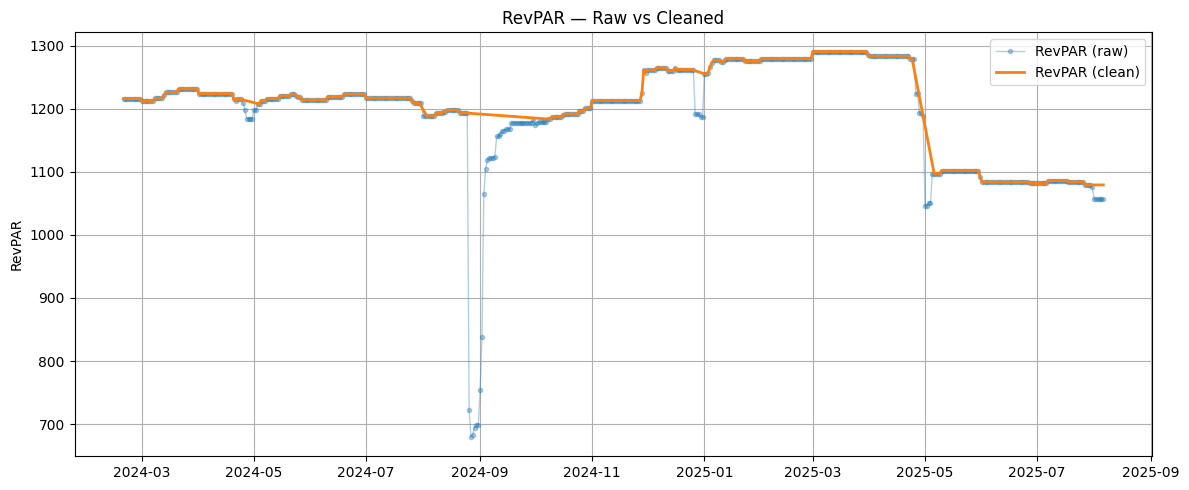

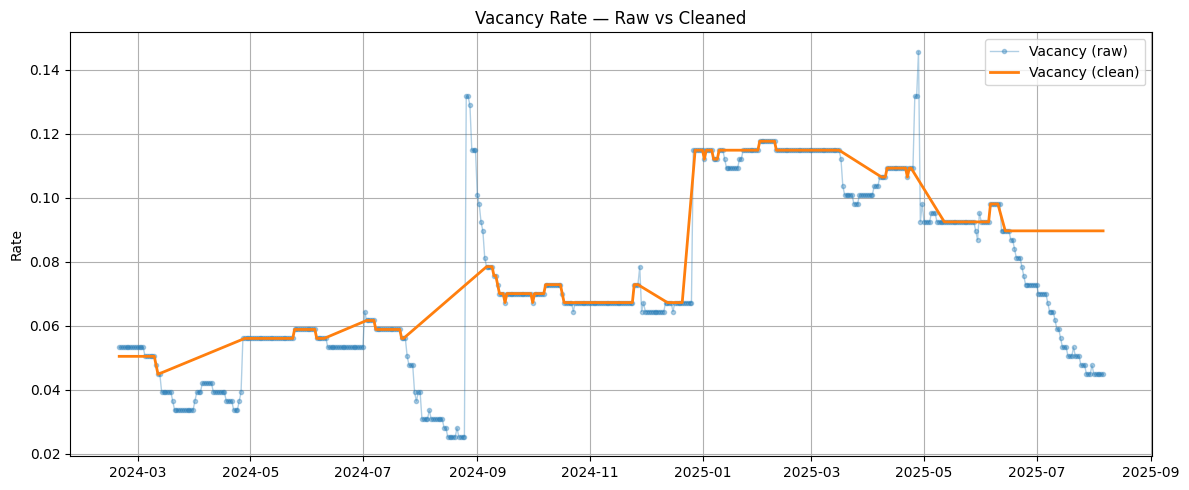

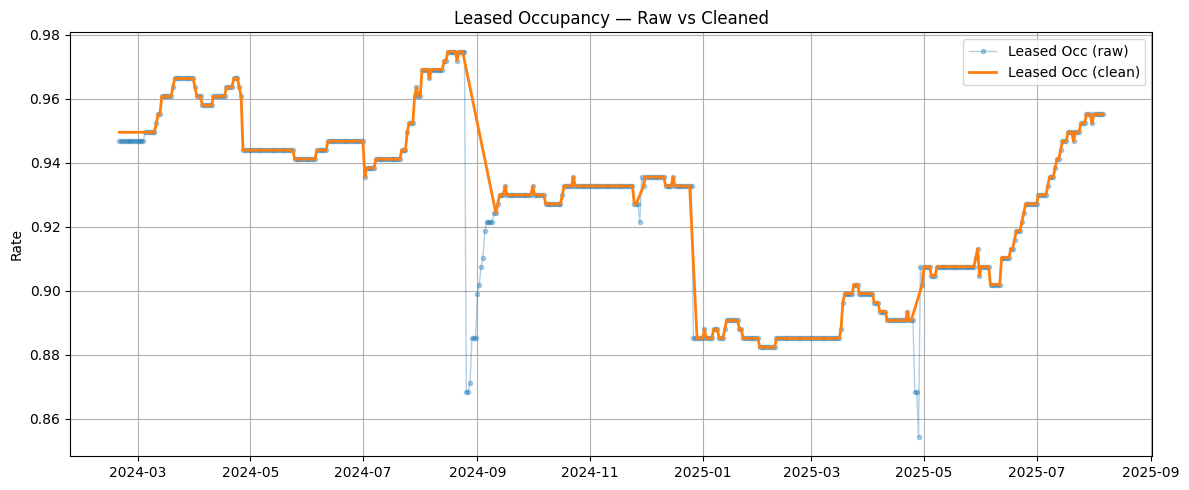

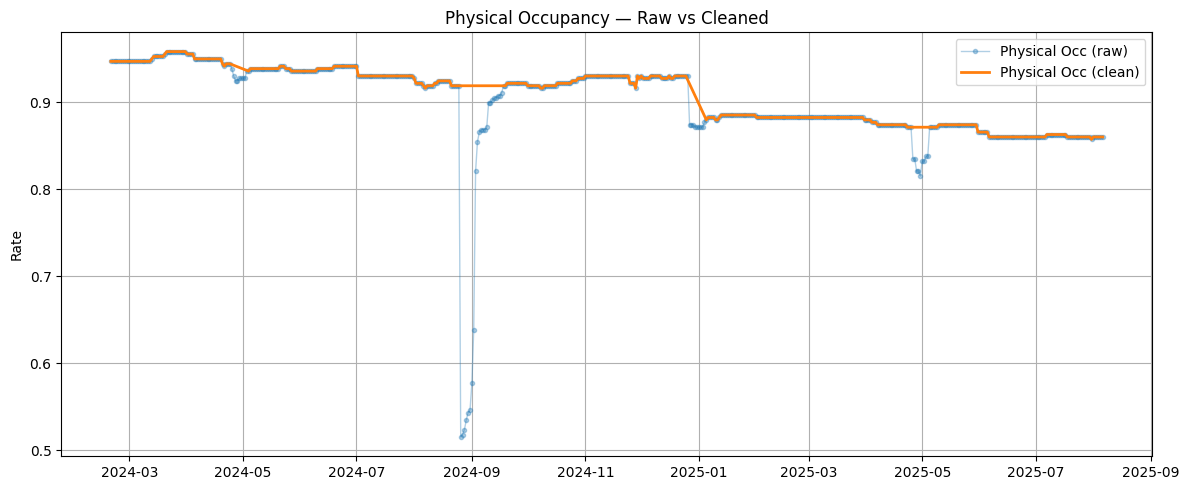

In [126]:
def bridge_short_dips(s, win=120, pct_thresh=0.99, up_pct=1.25, max_run_days=120):
    s = s.copy()
    med = s.rolling(win, center=True, min_periods=1).median()
    bad_low = s < pct_thresh * med
    bad_high = s > up_pct * med
    bad = bad_low | bad_high
    bad = bad.rolling(3, center=True, min_periods=1).max().astype(bool)
    grp = (bad != bad.shift(fill_value=False)).cumsum()
    run_len = bad.groupby(grp).transform("size")
    bridge_mask = bad & (run_len <= max_run_days)
    return s.mask(bridge_mask).interpolate(method="time", limit_direction="both")

# Interpolate small gaps to avoid NaNs
for col in ["ADR_occ","physical_occ_rate","leased_occ_rate","vacancy_rate","RevPAR_raw"]:
    daily[col] = daily[col].interpolate(limit_direction="both")

daily["RevPAR_clean"]       = bridge_short_dips(daily["RevPAR_raw"])
daily["vacancy_rate_clean"] = bridge_short_dips(daily["vacancy_rate"])
daily["leased_occ_clean"]   = bridge_short_dips(daily["leased_occ_rate"])
daily["physical_occ_clean"] = bridge_short_dips(daily["physical_occ_rate"])

# RevPAR raw vs cleaned
plt.figure(figsize=(12,5))
plt.plot(daily.index, daily["RevPAR_raw"],  alpha=0.35, marker=".", linewidth=1, label="RevPAR (raw)")
plt.plot(daily.index, daily["RevPAR_clean"], linewidth=2, label="RevPAR (clean)")
plt.title("RevPAR — Raw vs Cleaned")
plt.ylabel("RevPAR")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Vacancy raw vs cleaned
plt.figure(figsize=(12,5))
plt.plot(daily.index, daily["vacancy_rate"],       alpha=0.35, marker=".", linewidth=1, label="Vacancy (raw)")
plt.plot(daily.index, daily["vacancy_rate_clean"], linewidth=2, label="Vacancy (clean)")
plt.title("Vacancy Rate — Raw vs Cleaned")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Leased occupancy raw vs cleaned
plt.figure(figsize=(12,5))
plt.plot(daily.index, daily["leased_occ_rate"],   alpha=0.35, marker=".", linewidth=1, label="Leased Occ (raw)")
plt.plot(daily.index, daily["leased_occ_clean"],  linewidth=2, label="Leased Occ (clean)")
plt.title("Leased Occupancy — Raw vs Cleaned")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Physical occupancy raw vs cleaned
plt.figure(figsize=(12,5))
plt.plot(daily.index, daily["physical_occ_rate"],   alpha=0.35, marker=".", linewidth=1, label="Physical Occ (raw)")
plt.plot(daily.index, daily["physical_occ_clean"],  linewidth=2, label="Physical Occ (clean)")
plt.title("Physical Occupancy — Raw vs Cleaned")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

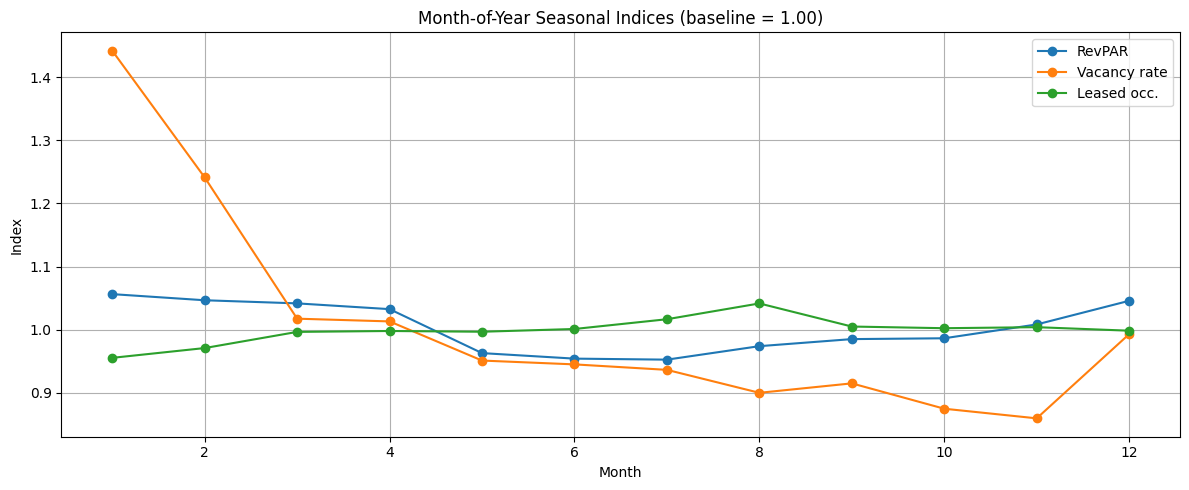

In [127]:
def seasonal_index(series, bucket):
    tmp = pd.DataFrame({"y": series, "b": bucket})
    grp = tmp.groupby("b")["y"].mean()
    return grp / tmp["y"].mean()

mo = daily.index.month
revpar_moy_idx   = seasonal_index(daily["RevPAR_clean"],       mo)
vacancy_moy_idx  = seasonal_index(daily["vacancy_rate_clean"], mo)
leased_moy_idx   = seasonal_index(daily["leased_occ_clean"],   mo)

plt.figure(figsize=(12,5))
plt.plot(revpar_moy_idx.index,  revpar_moy_idx.values,  marker="o", label="RevPAR")
plt.plot(vacancy_moy_idx.index, vacancy_moy_idx.values, marker="o", label="Vacancy rate")
plt.plot(leased_moy_idx.index,  leased_moy_idx.values,  marker="o", label="Leased occ.")
plt.title("Month-of-Year Seasonal Indices (baseline = 1.00)")
plt.xlabel("Month")
plt.ylabel("Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

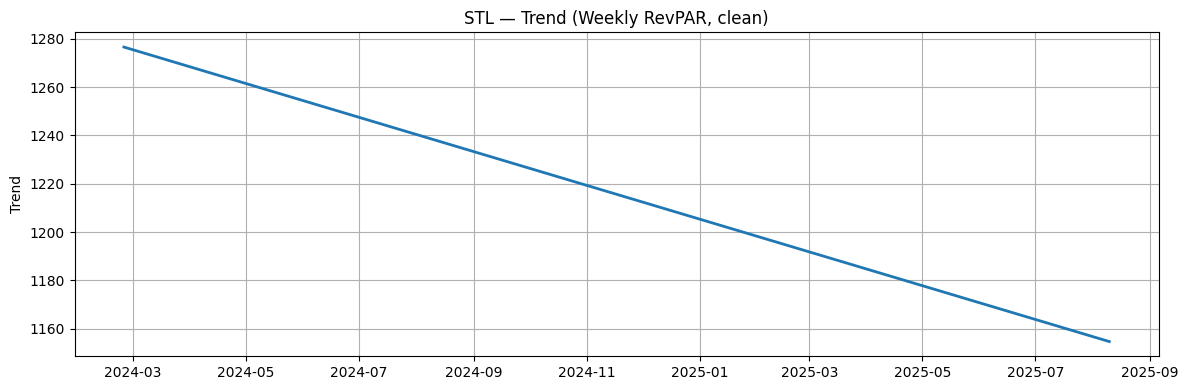

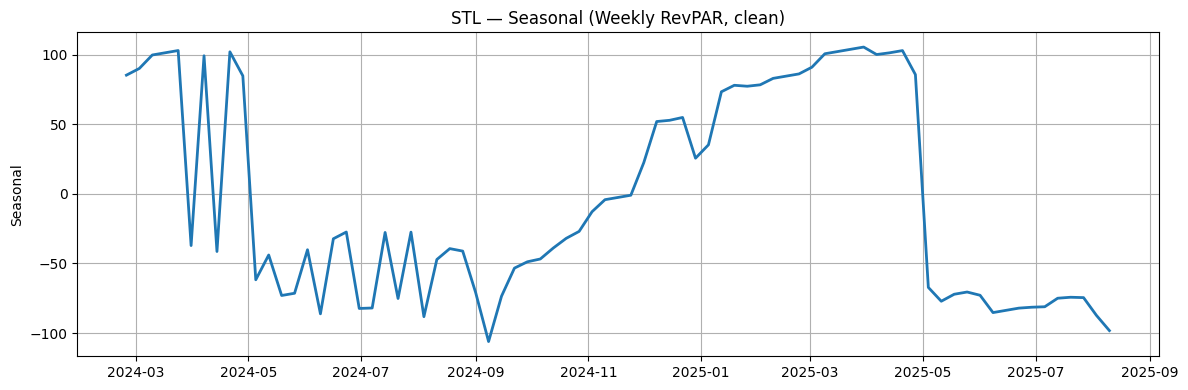

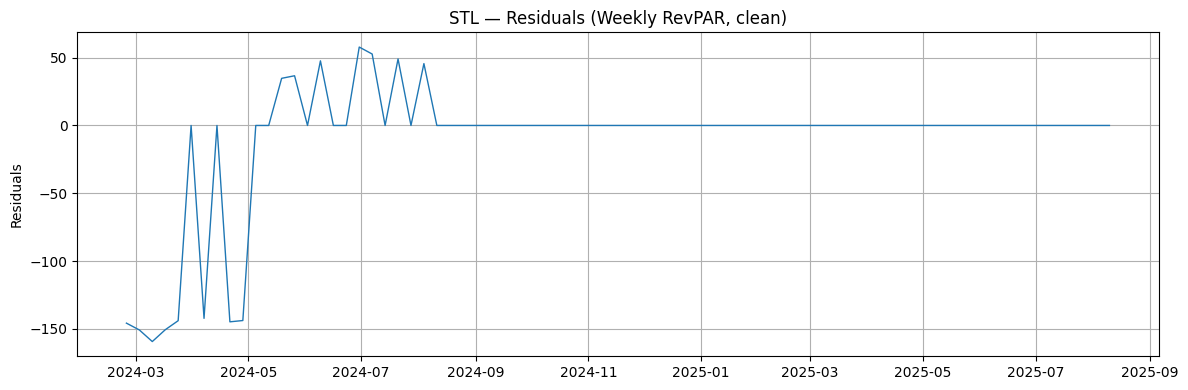

In [119]:
from statsmodels.tsa.seasonal import STL
# STL Decomposition
r = daily["RevPAR_clean"].asfreq("D").interpolate().resample("W").mean()

stl = STL(r, period=52, robust=True)
res = stl.fit()

# Trend
plt.figure(figsize=(12,4))
plt.plot(r.index, res.trend, linewidth=2)
plt.title("STL — Trend (Weekly RevPAR, clean)")
plt.ylabel("Trend")
plt.grid(True)
plt.tight_layout()
plt.show()

# Seasonal
plt.figure(figsize=(12,4))
plt.plot(r.index, res.seasonal, linewidth=2)
plt.title("STL — Seasonal (Weekly RevPAR, clean)")
plt.ylabel("Seasonal")
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual
plt.figure(figsize=(12,4))
plt.plot(r.index, res.resid, linewidth=1)
plt.title("STL — Residuals (Weekly RevPAR, clean)")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()